## Project Template (Deepnote)

You can use this notebook as a starting point for your class project and/or the extra exercise for graduate students in Deepnote. It comes set up with the dependencies we use in class, so you don't have to install these yourself.

**Notes:**
- To use this in your own workspace, click “Duplicate” for the project in Deepnote.
- Class dependencies, namely `drake` and the `manipulation` package, are already preinstalled in the Deepnote image for this course, as well as a bunch of other dependencies that these packages depend on or that we use in class
- To see the full list of installed dependencies, as well as version numbers etc, see this file: [pyproject.toml](https://github.com/RussTedrake/manipulation/blob/master/pyproject.toml).
  - **Note**: we install all the extra dependencies, including the `dev` dependencies, into the Docker image that this deepnote project runs on.


### (Advanced Users) Installing additional dependencies

Here we show you how to install additional packages into this Deepnote project. We will use the package [gcsopt](https://pypi.org/project/gcsopt/) as an example. To install additional dependencies, you have two choices:
- **Recommended** (automatically installs your dependencies every time you boot the Deepnote machine):
  1. Add the dependency to the list of dependencies in `reqirements.txt` on the left.  
      - **Note**: Make sure to NOT remove the text that is already in the file. You should add your dependencies on new lines AFTER `manipulation=year.month.day`. For our example, the file contents will look like:
          ```
          --extra-index-url https://drake-packages.csail.mit.edu/whl/nightly
          manipulation==2025.9.23
          gcsopt
          ```
  2. Restart the Deepnote machine (or run the `Init` notebook)
- **Alternatively:** Run `!pip install gcsopt` within a cell in the Deepnote notebook. You will have to do this everytime you restart your Deepnote machine.

### (Advanced Users) Updating the `manipulation` version
We continually add new features to the `manipulation` package, which is automatically updated in Deepnote. However, after you first click "Duplicate", you will stop receiving these updates. Follow these steps to update your version to the latest version:
1. Find the latest version number for `manipulation` on the [PyPi package page](https://pypi.org/project/manipulation/#history).
2. Update the version number for `manipulation=year.month.day` in the `requirements.txt` file on the left
3. Restart the Deepnote machine (or run the `Init` notebook)

The changes will persist every time you start your Deepnote machine.

Good luck!

---


## Placeholder code: iiwa Simulation

As a starting point, the code below sets up a simple simulation with a single iiwa, visualized in Meshcat.

### Setup and imports
Let us first get our imports out of the way:

In [1]:
from pydrake.all import (
    DiagramBuilder,
    Simulator,
    StartMeshcat,
)

from manipulation.station import (
    LoadScenario,
    MakeHardwareStation,
)

from manipulation import running_as_notebook

import matplotlib.pyplot as plt
import numpy as np

/usr/local/lib/python3.12/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


### Meshcat Visualization

As always, let's start Meshcat for our 3D visualization!

In [2]:
# Start meshcat for visualization
meshcat = StartMeshcat()
print("Click the link above to open Meshcat in your browser!")

INFO:drake:Meshcat listening for connections at http://localhost:7000


Click the link above to open Meshcat in your browser!


In [52]:
scenario_string = """directives:
# add robot
- add_model:
    name: iiwa
    file: package://drake_models/iiwa_description/urdf/iiwa14_primitive_collision.urdf
    default_joint_positions:
      iiwa_joint_1: [-1.57]
      iiwa_joint_2: [0.1]
      iiwa_joint_3: [0]
      iiwa_joint_4: [-1.2]
      iiwa_joint_5: [0]
      iiwa_joint_6: [1.6]
      iiwa_joint_7: [0]
- add_weld:
    parent: world
    child: iiwa::iiwa_link_0

# add gripper
- add_model:
    name: wsg
    file: package://manipulation/hydro/schunk_wsg_50_with_tip.sdf
- add_weld:
    parent: iiwa::iiwa_link_7
    child: wsg::body
    X_PC:
        translation: [0, 0, 0.09]
        rotation: !Rpy { deg: [90, 0, 90]}

# add camera mounted to world 
- add_frame:
    name: camera0_origin
    X_PF:
        base_frame: world
        rotation: !Rpy { deg: [270, 0.0, 90.0]}
        translation: [1.2, -0.5, 0.5]
- add_model:
    name: camera0
    file: package://manipulation/camera_box.sdf
- add_weld:
    parent: camera0_origin
    child: camera0::base

# add camera mounted to robot wrist
- add_frame:
    name: camera_wrist
    X_PF:
      base_frame: iiwa::iiwa_link_7
      translation: [-0.05, 0, 0.1]   # 10 cm ahead of wrist
      rotation: !Rpy {deg: [0, 00, -90]}
- add_model:
    name: camera1
    file: package://manipulation/camera_box.sdf
- add_weld:
    parent: iiwa::camera_wrist
    child: camera1::base

# add cabinet
- add_model:
    name: cabinet
    file: package://drake_models/manipulation_station/cupboard.sdf
- add_frame:
    name: cabinet_origin
    X_PF:
      base_frame: world
      translation: [0, -1.1, 0.4]    # x, y, z in meters
      rotation: !Rpy { deg: [0, 0, 90]}  # roll, pitch, yaw
- add_weld:
    parent: cabinet_origin
    child: cabinet::cupboard_body

cameras:
  camera0:
    name: camera0
    depth: True
    X_PB:
      base_frame: camera0::base
  camera1:
    name: camera1
    depth: True
    X_PB:
      base_frame: camera1::base

model_drivers:
  iiwa: !IiwaDriver
    control_mode: position_only
    hand_model_name: wsg
  wsg: !SchunkWsgDriver {}
"""
scenario = LoadScenario(data=scenario_string)
station = MakeHardwareStation(scenario, meshcat=meshcat)
builder = DiagramBuilder()
builder.AddSystem(station)
diagram = builder.Build()
context = diagram.CreateDefaultContext()

simulator = Simulator(diagram)
simulator.set_target_realtime_rate(1.0)
simulator.AdvanceTo(0.0)

RuntimeError: InputPort::Eval(): required InputPort[0] (u0) of System ::_::station::iiwa::velocity_interpolator::drake/systems/Multiplexer@00000000345832a0 (Multiplexer<double>) is not connected

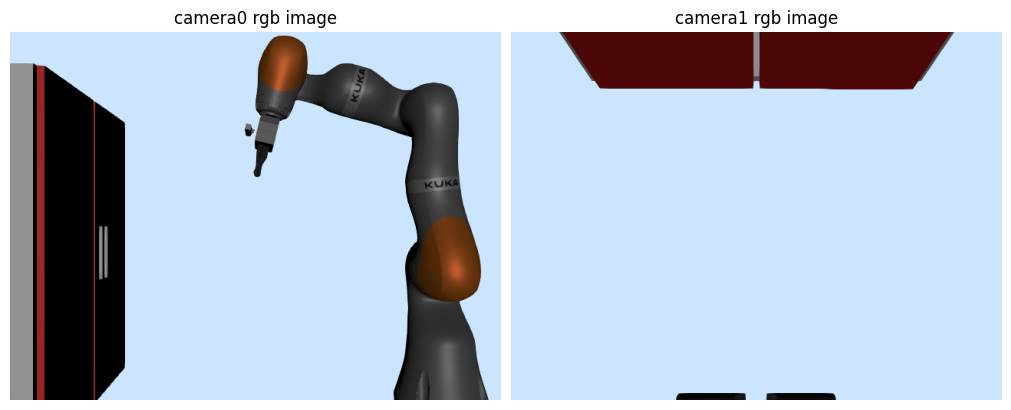

In [53]:
# run the following cell to visualize the rgb outputs of each of the cameras
cameras = ["camera0", "camera1"]
station_context = diagram.GetSubsystemContext(station, context)

fig, axes = plt.subplots(
    1, len(cameras), figsize=(5 * len(cameras), 4), constrained_layout=True
)
# cam = cameras[0]
# ax = axes
for ax, cam in zip(axes, cameras):
    img = station.GetOutputPort(f"{cam}.rgb_image").Eval(station_context)
    arr = np.array(img.data, copy=False).reshape(img.height(), img.width(), -1)
    im = ax.imshow(arr)
    ax.set_title(f"{cam} rgb image")
    ax.axis("off")

if running_as_notebook:
    plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=cf4fb7c2-18e7-48b8-93e7-63f0209e538b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>